Versión de TensorFlow: 2.18.0
GPU disponible: []
=== Sección 1.2: Dataset ===
UserHistory - Primeras filas:
    HistoryID  UserID  DestinationID   VisitDate  ExperienceRating
0          1     525            760  2024-01-01                 3
1          2     184            532  2024-02-15                 5
2          3     897            786  2024-03-20                 2
3          4     470            660  2024-01-01                 1
4          5     989            389  2024-02-15                 4

Destinations - Primeras filas:
    DestinationID               Name              State        Type  \
0              1          Taj Mahal      Uttar Pradesh  Historical   
1              2        Goa Beaches                Goa       Beach   
2              3        Jaipur City          Rajasthan        City   
3              4  Kerala Backwaters             Kerala      Nature   
4              5         Leh Ladakh  Jammu and Kashmir   Adventure   

   Popularity BestTimeToVisit  
0    8.69

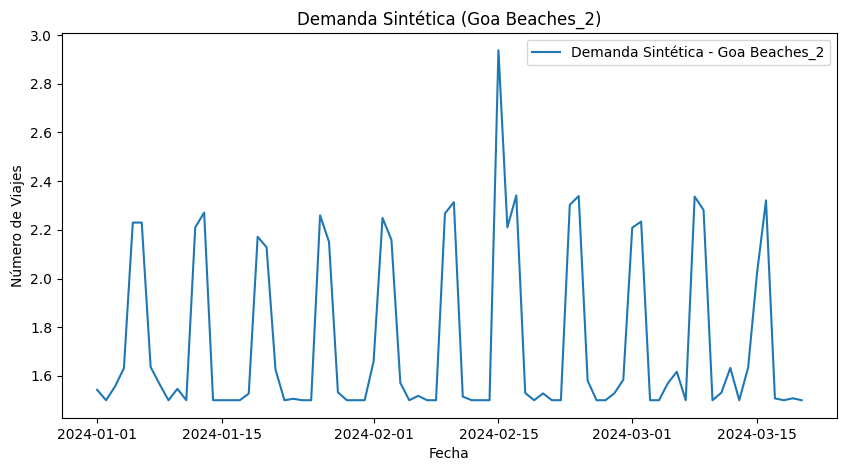

Forma de X_train: (58, 7, 1)

Métricas para Goa Beaches_2:
Entrenamiento - RMSE: 0.20, MAE: 0.12, MAPE: 6.82%, R²: 0.68
Prueba - RMSE: 0.15, MAE: 0.12, MAPE: 7.11%, R²: 0.78
Guardado: /content/predicciones_Goa Beaches_2.csv


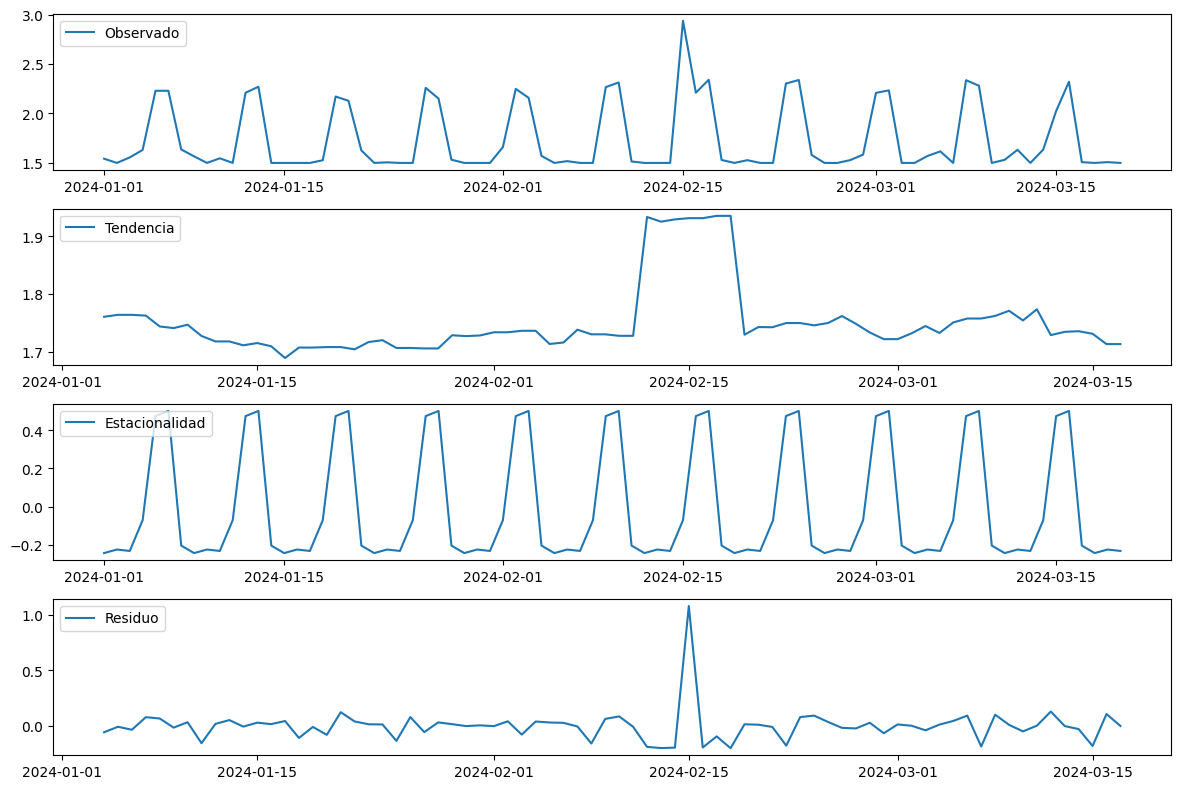

Guardado: /content/descomposicion_Goa Beaches_2.png

Procesando ruta: Jaipur City_3


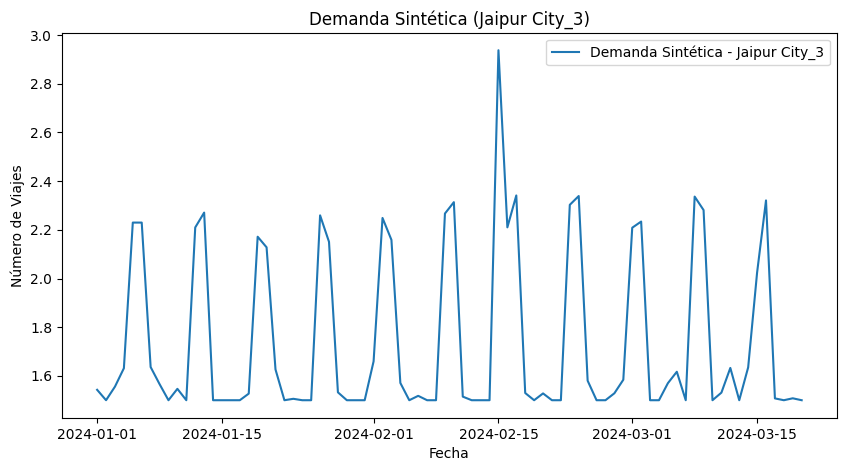

Forma de X_train: (58, 7, 1)

Métricas para Jaipur City_3:
Entrenamiento - RMSE: 0.20, MAE: 0.12, MAPE: 6.97%, R²: 0.68
Prueba - RMSE: 0.15, MAE: 0.12, MAPE: 7.09%, R²: 0.79
Guardado: /content/predicciones_Jaipur City_3.csv


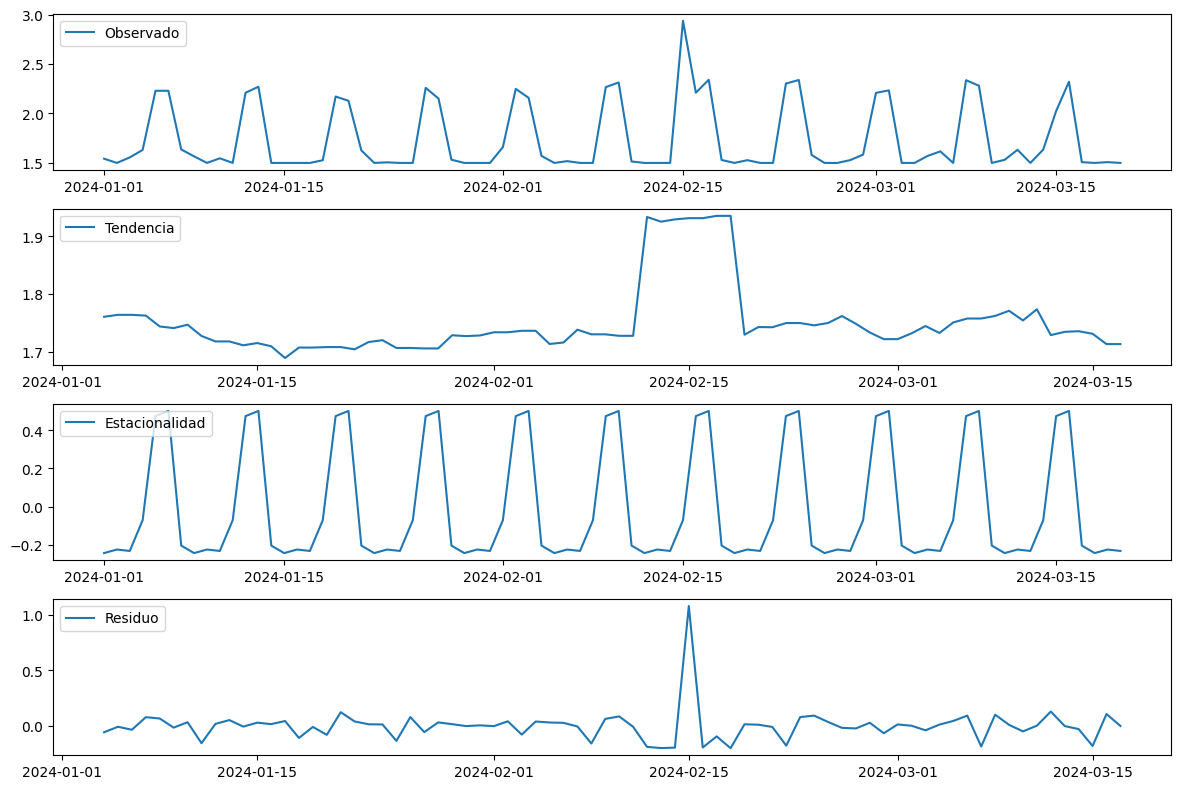

Guardado: /content/descomposicion_Jaipur City_3.png

Procesando ruta: Kerala Backwaters_4


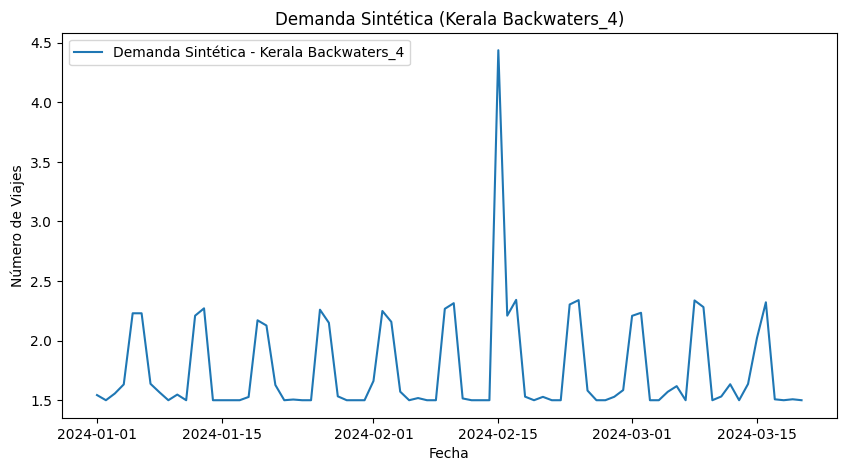

Forma de X_train: (58, 7, 1)

Métricas para Kerala Backwaters_4:
Entrenamiento - RMSE: 0.39, MAE: 0.20, MAPE: 10.93%, R²: 0.33
Prueba - RMSE: 0.21, MAE: 0.17, MAPE: 10.63%, R²: 0.58
Guardado: /content/predicciones_Kerala Backwaters_4.csv


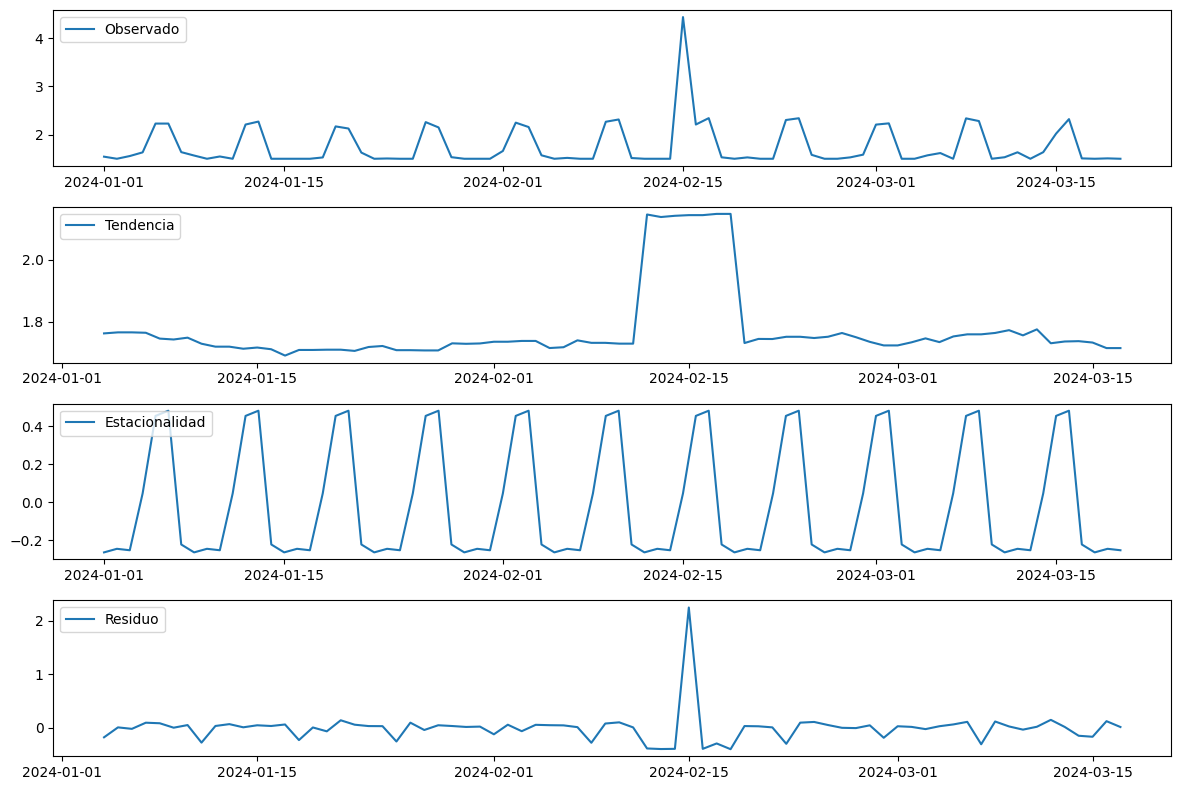

Guardado: /content/descomposicion_Kerala Backwaters_4.png

Procesando ruta: Leh Ladakh_5


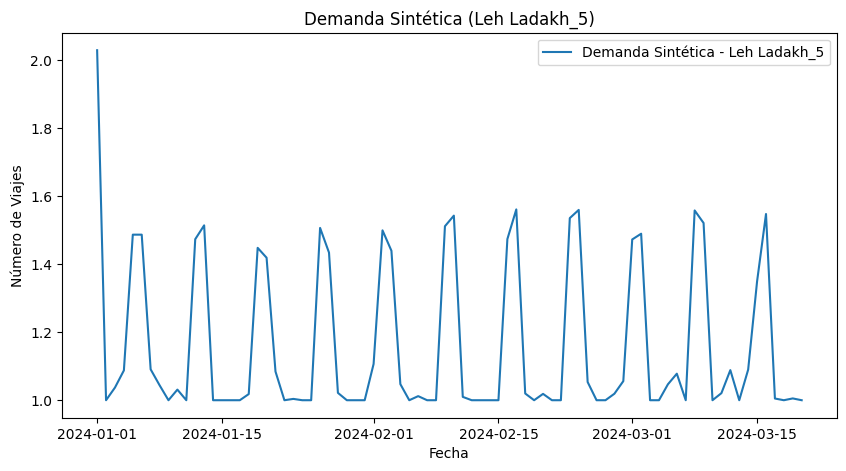

Forma de X_train: (58, 7, 1)

Métricas para Leh Ladakh_5:
Entrenamiento - RMSE: 0.06, MAE: 0.05, MAPE: 4.60%, R²: 0.91
Prueba - RMSE: 0.08, MAE: 0.06, MAPE: 5.01%, R²: 0.88
Guardado: /content/predicciones_Leh Ladakh_5.csv


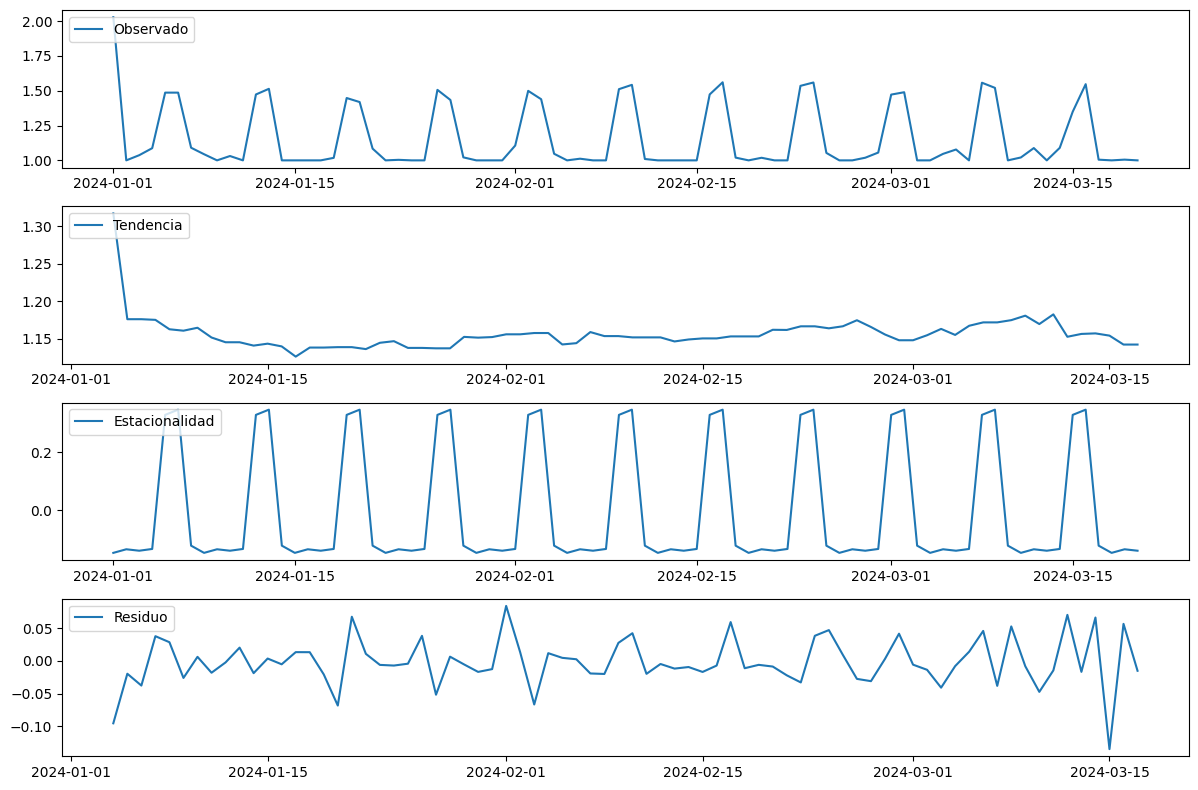

Guardado: /content/descomposicion_Leh Ladakh_5.png

Procesando ruta: Taj Mahal_6


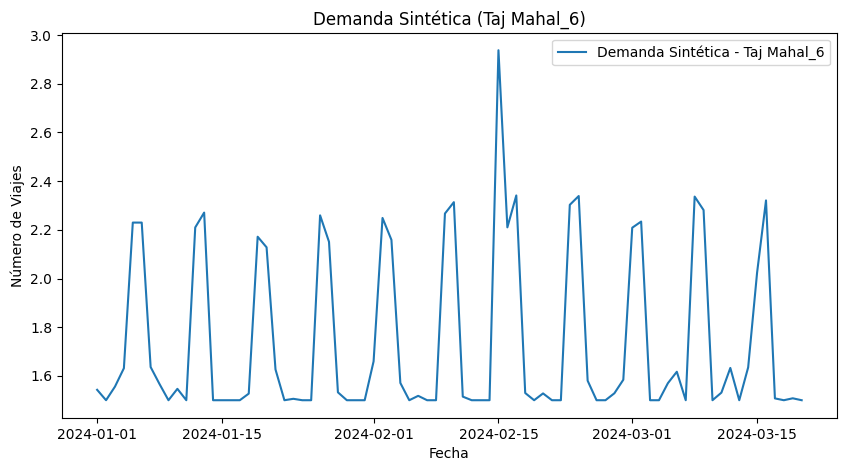

Forma de X_train: (58, 7, 1)

Métricas para Taj Mahal_6:
Entrenamiento - RMSE: 0.20, MAE: 0.12, MAPE: 6.74%, R²: 0.68
Prueba - RMSE: 0.13, MAE: 0.11, MAPE: 6.23%, R²: 0.83
Guardado: /content/predicciones_Taj Mahal_6.csv


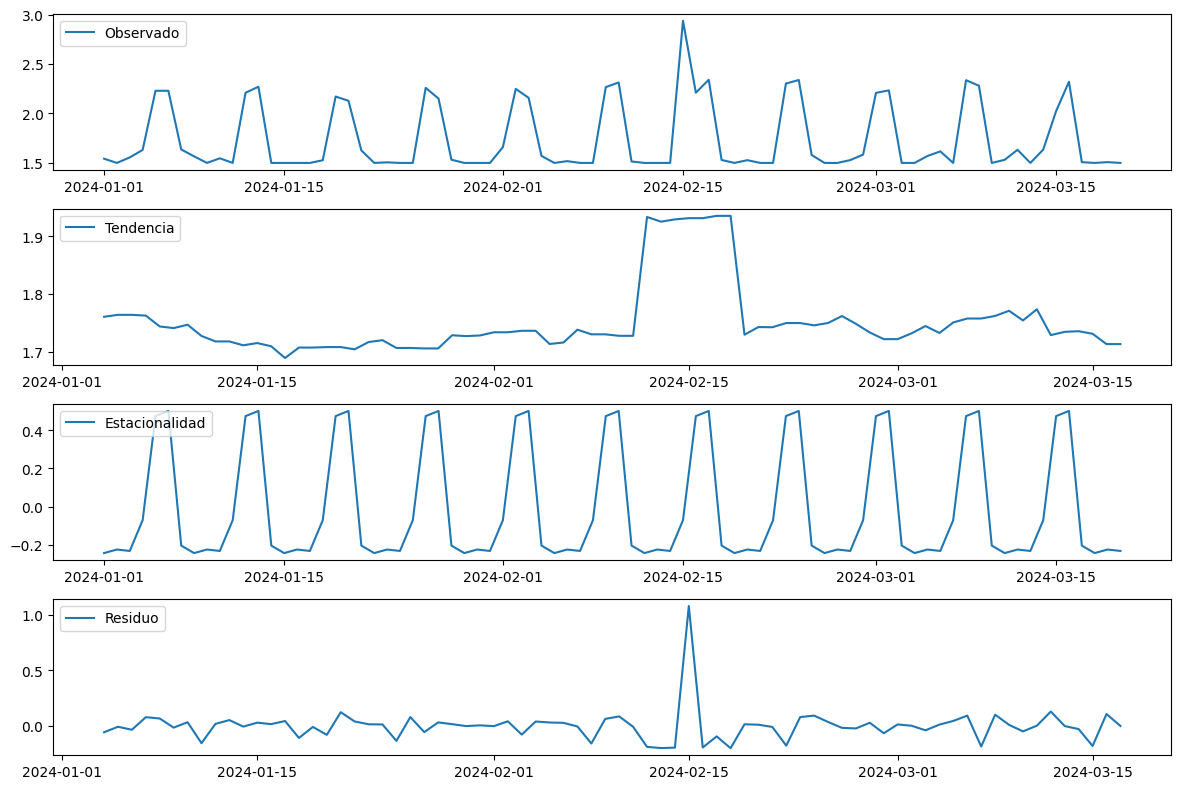

Guardado: /content/descomposicion_Taj Mahal_6.png

=== Sección 1.7: Conclusiones ===
El modelo LSTM predice la demanda de transporte, pero usa datos sintéticos debido a solo 3 fechas únicas.
Limitaciones: Las predicciones reflejan suposiciones (estacionalidad semanal artificial).
Recomendación: Recolectar más datos históricos para mejorar la precisión.


In [7]:
# modulo1_prediccion_demanda.py
# Módulo 1: Predicción de Demanda de Transporte
# Propósito: Generar predicciones de demanda para destinos turísticos usando LSTM
# Nota: Debido a solo 3 fechas únicas por destino, se usa aumentación de datos
# Archivos se guardan en /content/ y se visualizan en Colab para verificación

# === Importar librerías ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from keras.models import Sequential
from keras.layers import LSTM, Dense
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
import os
warnings.filterwarnings('ignore')

# Verificar TensorFlow y GPU
import tensorflow as tf
print("Versión de TensorFlow:", tf.__version__)
print("GPU disponible:", tf.config.list_physical_devices('GPU'))

# === Sección 1.1: Descripción del problema ===
# Objetivo: Predecir la demanda de transporte (número de viajes) para destinos turísticos
# Desafío: Solo 3 fechas únicas por destino, requiere aumentación de datos
# Enfoque: Usar LSTM con series temporales sintéticas, integradas en Streamlit

# === Sección 1.2: Dataset ===
# Cargar datos
try:
    user_history = pd.read_csv('/content/Final_Updated_Expanded_UserHistory.csv')
    destinations = pd.read_csv('/content/Expanded_Destinations.csv')
except FileNotFoundError as e:
    print(f"Error: {e}. Sube los archivos CSV a /content/")
    exit()

# Mostrar información del dataset
print("=== Sección 1.2: Dataset ===")
print("UserHistory - Primeras filas:\n", user_history.head())
print("\nDestinations - Primeras filas:\n", destinations.head())
print("\nColumnas de UserHistory:", user_history.columns.tolist())
print("\nNúmero de filas en UserHistory:", len(user_history))
print("\nDestinos únicos:", user_history['DestinationID'].nunique())
print("\nFechas únicas:", user_history['VisitDate'].nunique())
print("\nRango de fechas:", user_history['VisitDate'].min(), "a", user_history['VisitDate'].max())

# === Sección 1.3: Preprocesamiento ===
# Convertir VisitDate a datetime
user_history['VisitDate'] = pd.to_datetime(user_history['VisitDate'], errors='coerce')
print("\nFechas inválidas:", user_history['VisitDate'].isnull().sum())

# Agregar visitas por fecha y destino
demand = user_history.groupby(['VisitDate', 'DestinationID']).size().reset_index(name='Trips')

# Crear rango diario (01-01-2024 a 20-03-2024, ~79 días)
date_range = pd.date_range(start='2024-01-01', end='2024-03-20', freq='D')
full_dates = pd.DataFrame({'VisitDate': date_range})

# Pivotear datos
demand_pivot = demand.pivot(index='VisitDate', columns='DestinationID', values='Trips').fillna(0)
demand_pivot = demand_pivot.reindex(date_range, fill_value=0)

# Mapear nombres únicos para evitar Length mismatch
dest_names = destinations.set_index('DestinationID')['Name'].to_dict()
demand_pivot.columns = [f"{dest_names.get(col, f'Destination_{col}')}_{col}" for col in demand_pivot.columns]
print("\nColumnas de demand_pivot:", demand_pivot.columns.tolist())
print("Tamaño de demand_pivot:", demand_pivot.shape)

# Nota sobre aumentación
print("\nNOTA: Debido a solo 3 fechas únicas por destino, se aplicó aumentación de datos "
      "(interpolación lineal, estacionalidad semanal artificial, ruido, ajustes por BestTimeToVisit). "
      "Esto genera series sintéticas, limitando la validez de las predicciones.")

# === Sección 1.4: Diseño de modelos ===
# Función para crear secuencias
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

# Procesar múltiples rutas (limitado a 5 para pruebas)
predictions = {}
seq_length = 7  # Capturar estacionalidad semanal
for dest_id in demand_pivot.columns[:5]:
    print(f"\nProcesando ruta: {dest_id}")

    # Seleccionar datos de la ruta
    route_data = demand_pivot[[dest_id]].copy()
    route_data.columns = ['Trips']

    # Aumento de datos
    route_data['Trips'] = route_data['Trips'].interpolate(method='linear')
    route_data['Trips'] = route_data['Trips'] + 1  # Evitar ceros
    days_of_week = pd.Series(route_data.index.dayofweek, index=route_data.index)
    seasonal_factor = np.where(days_of_week.isin([4, 5]), 1.5, 1.0)
    route_data['Trips'] = route_data['Trips'] * seasonal_factor
    np.random.seed(42)
    noise = np.random.normal(0, 0.05 * route_data['Trips'].mean(), len(route_data))
    route_data['Trips'] = np.maximum(route_data['Trips'] + noise, 1)
    dest_id_num = int(dest_id.split('_')[-1])
    try:
        best_time = destinations[destinations['DestinationID'] == dest_id_num]['BestTimeToVisit'].iloc[0]
        if 'Jan' in best_time or 'Feb' in best_time or 'Mar' in best_time:
            month_factor = route_data.index.month.isin([1, 2, 3]) * 0.5 + 1.0
            route_data['Trips'] = route_data['Trips'] * month_factor
            route_data['Trips'] = np.maximum(route_data['Trips'], 1)
    except IndexError:
        print(f"Advertencia: No se encontró BestTimeToVisit para DestinationID {dest_id_num}")

    # Graficar serie sintética para verificación
    plt.figure(figsize=(10, 5))
    plt.plot(route_data.index, route_data['Trips'], label=f'Demanda Sintética - {dest_id}')
    plt.title(f'Demanda Sintética ({dest_id})')
    plt.xlabel('Fecha')
    plt.ylabel('Número de Viajes')
    plt.legend()
    plt.show()

    # Normalizar datos
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(route_data['Trips'].values.reshape(-1, 1))
    X, y = create_sequences(scaled_data, seq_length)

    # Verificar secuencias
    if len(X) < 10:
        print(f"Ruta {dest_id} omitida: pocas secuencias.")
        continue

    # Dividir datos
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    print("Forma de X_train:", X_train.shape)

    # Crear y entrenar modelo LSTM
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(seq_length, 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1 if len(X_train) > 10 else 0.0, verbose=0)

    # === Sección 1.5: Evaluación ===
    # Predicciones
    train_predict = model.predict(X_train, verbose=0)
    test_predict = model.predict(X_test, verbose=0)
    train_predict = scaler.inverse_transform(train_predict)
    y_train_inv = scaler.inverse_transform(y_train)
    test_predict = scaler.inverse_transform(test_predict)
    y_test_inv = scaler.inverse_transform(y_test)

    # Métricas
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        y_true = np.where(y_true == 0, 1e-10, y_true)
        return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

    train_rmse = np.sqrt(mean_squared_error(y_train_inv, train_predict))
    train_mae = mean_absolute_error(y_train_inv, train_predict)
    train_mape = mean_absolute_percentage_error(y_train_inv, train_predict)
    train_r2 = r2_score(y_train_inv, train_predict)
    test_rmse = np.sqrt(mean_squared_error(y_test_inv, test_predict))
    test_mae = mean_absolute_error(y_test_inv, test_predict)
    test_mape = mean_absolute_percentage_error(y_test_inv, test_predict)
    test_r2 = r2_score(y_test_inv, test_predict)

    print(f"\nMétricas para {dest_id}:")
    print(f"Entrenamiento - RMSE: {train_rmse:.2f}, MAE: {train_mae:.2f}, MAPE: {train_mape:.2f}%, R²: {train_r2:.2f}")
    print(f"Prueba - RMSE: {test_rmse:.2f}, MAE: {test_mae:.2f}, MAPE: {test_mape:.2f}%, R²: {test_r2:.2f}")

    # === Sección 1.6: Resultados ===
    # Predicciones futuras (30 días)
    last_sequence = scaled_data[-seq_length:]
    future_predictions = []
    future_dates = pd.date_range(start=route_data.index[-1] + pd.Timedelta(days=1), periods=30, freq='D')
    for _ in range(30):
        last_sequence_reshaped = last_sequence.reshape((1, seq_length, 1))
        next_pred = model.predict(last_sequence_reshaped, verbose=0)
        future_predictions.append(next_pred[0, 0])
        last_sequence = np.append(last_sequence[1:], next_pred)
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
    predictions[dest_id] = pd.DataFrame(future_predictions, index=future_dates, columns=['Predicción'])

    # Guardar predicciones en /content/
    predictions[dest_id].to_csv(f'/content/predicciones_{dest_id}.csv')
    print(f"Guardado: /content/predicciones_{dest_id}.csv")

    # Descomposición aditiva
    try:
        decomposition = seasonal_decompose(route_data['Trips'], model='additive', period=7)
        plt.figure(figsize=(12, 8))
        plt.subplot(411)
        plt.plot(decomposition.observed, label='Observado')
        plt.legend(loc='upper left')
        plt.subplot(412)
        plt.plot(decomposition.trend, label='Tendencia')
        plt.legend(loc='upper left')
        plt.subplot(413)
        plt.plot(decomposition.seasonal, label='Estacionalidad')
        plt.legend(loc='upper left')
        plt.subplot(414)
        plt.plot(decomposition.resid, label='Residuo')
        plt.legend(loc='upper left')
        plt.tight_layout()
        plt.savefig(f'/content/descomposicion_{dest_id}.png')
        plt.show()  # Mostrar gráfica en Colab
        plt.close()
        print(f"Guardado: /content/descomposicion_{dest_id}.png")
    except ValueError as e:
        print(f"Error en descomposición para {dest_id}: {e}")

# === Sección 1.7: Conclusiones ===
print("\n=== Sección 1.7: Conclusiones ===")
print("El modelo LSTM predice la demanda de transporte, pero usa datos sintéticos debido a solo 3 fechas únicas.")
print("Limitaciones: Las predicciones reflejan suposiciones (estacionalidad semanal artificial).")
print("Recomendación: Recolectar más datos históricos para mejorar la precisión.")